**Задание**

* Возьмите MNIST, обучите на нем сетку (LeNet)
* Возьмите какую-нить картинку (из mnist’а)
* Обучите шум, который при добавлении к оригинальной картинке, заставит ее ошибаться в пользу другого класса

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision as tv
from torchvision import models
from torchvision import transforms, utils
import torch.nn.functional as F
import time

import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

In [ ]:
def to_grayscale(image):
    image = torch.mean(image, dim=0)
    return image

def normalize(image):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])
    image = preprocess(image).unsqueeze(0).cuda()
    return image


def predict(image):
    _, index = vgg(image).data[0].max(0)
    return str(index.item())
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

In [ ]:
batch_size = 1
n_classes = 10
lr = 0.001
n_epochs = 8

In [ ]:
train_dataset = tv.datasets.MNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.MNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

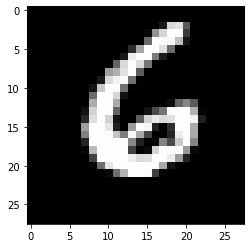

In [ ]:
testimg = train_dataset[90][0].numpy().reshape(28,28)
plt.imshow(testimg, cmap='gray')

In [ ]:
class lenet(nn.Module):
    def __init__(self, num_classes):
        super(lenet, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer1 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(320, 100)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(100, 50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, num_classes)
        
    def forward(self, y):
        output = self.layer(y)
        output = self.layer1(output)
        output = output.reshape(output.size(0), -1)
        output = self.fc(output)
        output = self.relu(output)
        output = self.fc1(output)
        output = self.relu1(output)
        output = self.fc2(output)
        return output


In [ ]:
model = lenet(n_classes)
model

lenet(
  (layer): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=320, out_features=100, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, n_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(n_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, n_epochs)

epoch 1, loss 0.2380, train acc 0.933, test acc 0.976, time 160.3 sec
epoch 2, loss 0.0578, train acc 0.982, test acc 0.983, time 148.9 sec
epoch 3, loss 0.0406, train acc 0.987, test acc 0.986, time 148.3 sec
epoch 4, loss 0.0318, train acc 0.990, test acc 0.987, time 148.4 sec
epoch 5, loss 0.0258, train acc 0.992, test acc 0.989, time 146.7 sec
epoch 6, loss 0.0215, train acc 0.994, test acc 0.989, time 145.3 sec
epoch 7, loss 0.0177, train acc 0.995, test acc 0.989, time 151.1 sec
epoch 8, loss 0.0146, train acc 0.996, test acc 0.988, time 151.3 sec


In [ ]:
model.eval()

lenet(
  (layer): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=320, out_features=100, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [ ]:
def test(model, test_iter, epsilon ):

    correct = 0
    adv_examples = []

    for X, y in test_iter:
        X.requires_grad = True
        output = model(X)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        #print('init_pred', init_pred, init_pred.shape)
        #print('y', y, y.shape)
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != y.item():
            continue
        loss = F.nll_loss(output, y)
        model.zero_grad()
        loss.backward()

        data_grad = X.grad.data
        perturbed_data = fgsm_attack(X, epsilon, data_grad)
        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == y.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_iter))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_iter), final_acc))

    return final_acc, adv_examples

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, test_iter, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9709 / 10000 = 0.9709
Epsilon: 0.05	Test Accuracy = 8425 / 10000 = 0.8425
Epsilon: 0.1	Test Accuracy = 6067 / 10000 = 0.6067
Epsilon: 0.15	Test Accuracy = 3130 / 10000 = 0.313
Epsilon: 0.2	Test Accuracy = 1100 / 10000 = 0.11
Epsilon: 0.25	Test Accuracy = 368 / 10000 = 0.0368
Epsilon: 0.3	Test Accuracy = 180 / 10000 = 0.018


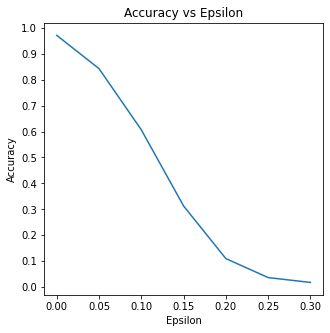

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

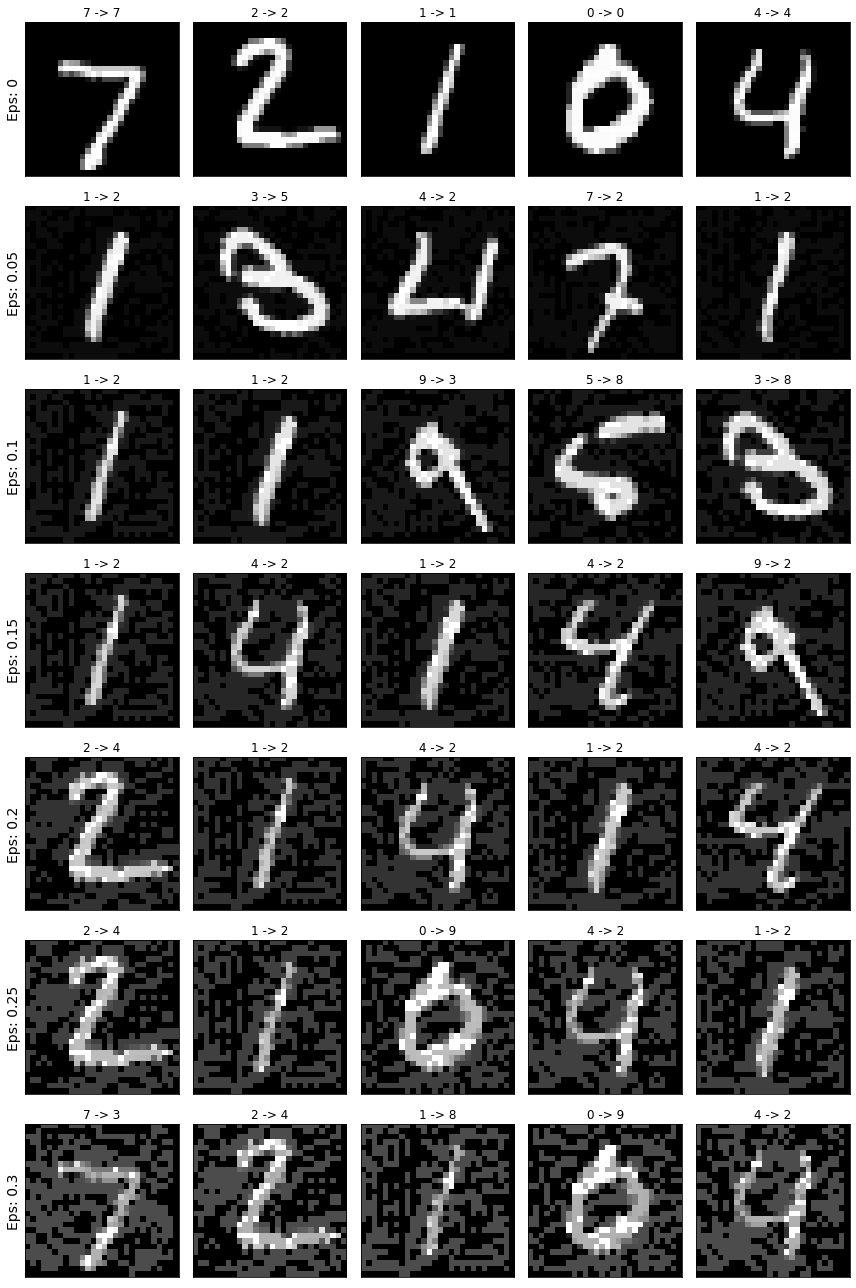

In [ ]:
cnt = 0
plt.figure(figsize=(12,18))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()